In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trashnet/dataset-resized/metal/metal375.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal341.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal374.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal383.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal215.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal113.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal213.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal226.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal147.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal90.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal130.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal63.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal149.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal344.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal8.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal68.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal323.jpg
/kaggle/input/trash

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Define paths
base_dir = '/kaggle/input/trashnet/dataset-resized'
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Prepare data
data = []
labels = []

for category in categories:
    path = os.path.join(base_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        data.append(img_path)
        labels.append(class_num)

# Split data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_data, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_data, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers except the last four
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 创建checkpoint文件夹
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'best_model.keras'), 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min'
)

# Calculate steps per epoch
train_steps = len(train_data) // 32
val_steps = len(test_data) // 32

# Train the model with the checkpoint callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=120,  
    validation_data=test_generator,
    validation_steps=val_steps,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

# Plot training history for accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('training_accuracy.png')
plt.show()

# Plot training history for loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.show()

Found 2021 validated image filenames.
Found 506 validated image filenames.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/120


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732430828.409791      96 service.cc:145] XLA service 0x7e83d8002f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732430828.409866      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/63 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.1719 - loss: 12.4015  

I0000 00:00:1732430840.098766      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/63 ━━━━━━━━━━━━━━━━━━━━ 23s 646ms/step - accuracy: 0.1914 - loss: 12.0185

In [ ]:
# Define categories
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Load the best model
best_model = load_model('/kaggle/input/model-best/best_model.keras')

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = best_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    return categories[predicted_class[0]]

# Example usage
img_path = '/kaggle/input/trashnet/dataset-resized/metal/metal12.jpg'
result = predict_image(img_path)
print(f'The image is predicted to be: {result}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


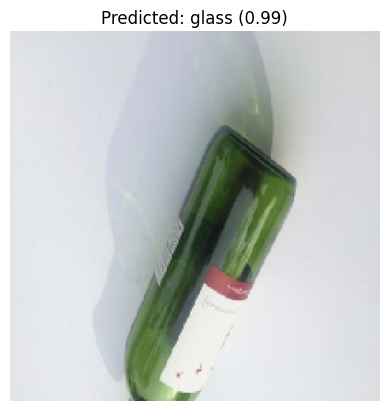

In [4]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define categories
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Load the best model
try:
    best_model = load_model('/kaggle/input/model-best/best_model.keras')
except Exception as e:
    print(f"Error loading model: {e}")

def predict_image(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        predictions = best_model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        confidence = np.max(predictions)
        
        return categories[predicted_class[0]], confidence, img
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None, None

def display_prediction(img_path):
    result, confidence, img = predict_image(img_path)
    if result:
        plt.imshow(img)
        plt.title(f'Predicted: {result} ({confidence:.2f})')
        plt.axis('off')
        plt.show()

# Example usage
img_path = '/kaggle/input/trashnet/dataset-resized/glass/glass105.jpg'
display_prediction(img_path)